## 載入資料集

In [1]:
import pandas as pd

train = pd.read_csv('./dataset/train.csv')
train.head()

,filename,label,target
0,dataset/train/ON_20210210T012001_2.wav,ON,0
1,dataset/train/BLADE FAULT_20200318T205806_1.wav,BLADE FAULT,3
2,dataset/train/OFF_20200318T204318_4.wav,OFF,1
3,dataset/train/FAN_GUARDS_20201210144646_5.wav,FAN,2
4,dataset/train/FAN_GUARDS_20201210144646_4.wav,FAN,2


In [2]:
from sklearn.model_selection import train_test_split

# 將資料集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(train, train['target'], test_size=0.05, stratify=train['target'], random_state=42)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (118, 3)
Testing set shape: (7, 3)


In [5]:
import tensorflow as tf
import tensorflow_io as tfio

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
        file_contents,
        desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

def extract_embedding(wav_data, label):
    ''' Run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(label, num_embeddings))

def create_train_dataset(filenames, targets, batch_size=8, cache=True, shuffle_buffer_size=1000):
    main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
    main_ds = main_ds.map(load_wav_for_map)
    main_ds = main_ds.map(extract_embedding).unbatch()

    if cache:
        main_ds = main_ds.cache()

    main_ds = main_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return main_ds


train_ds = create_train_dataset(X_train['filename'], X_train['target'], batch_size=8, shuffle_buffer_size=250)
test_ds = create_train_dataset(X_test['filename'], X_test['target'], batch_size=8, shuffle_buffer_size=250)

2024-01-28 15:51:49.683884: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


## 載入yamnet

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import scipy

2024-01-28 15:47:15.817442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 15:47:15.817471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 15:47:15.818661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 15:47:15.825286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 15:47:16.610075: W tensorflow/compiler/tf2

In [4]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

2024-01-28 15:47:20.164549: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [18]:
# # 假設你的 train_ds 已經被創建
## https://ithelp.ithome.com.tw/articles/10241789
# train_iterator = train_ds.as_numpy_iterator()

# # 從 iterator 中獲取一個 batch 的數據
# batch_data = next(train_iterator)

# # 從 batch_data 中分別獲取數據和標籤
# data_values = batch_data[0]  # 這裡假設數據在 batch_data 的第一個位置
# labels = batch_data[1]  # 這裡假設標籤在 batch_data 的第二個位置

# # 將 NumPy 陣列轉換為 Python 原生 list，以便更容易查看
# data_values = data_values.tolist()
# labels = labels.tolist()

# # 打印或使用數據和標籤
# print("Data values:", data_values)
# print("Labels:", labels)

## 建立遷移模型

In [6]:
tf.keras.backend.clear_session() # 清空網路暫存
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 527365 (2.01 MB)
Trainable params: 527365 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [8]:
history = my_model.fit(train_ds,
                       epochs=20,
                       callbacks=callback)

Epoch 1/20
140/140 [==============================] - 5s 22ms/step - loss: 0.1211 - accuracy: 0.9660
Epoch 2/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9937
Epoch 3/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 4/20
140/140 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 5/20
140/140 [==============================] - 0s 2ms/step - loss: 9.3564e-04 - accuracy: 1.0000
Epoch 6/20
140/140 [==============================] - 0s 2ms/step - loss: 6.6570e-04 - accuracy: 1.0000
Epoch 7/20
140/140 [==============================] - 0s 2ms/step - loss: 4.9235e-04 - accuracy: 1.0000
Epoch 8/20
140/140 [==============================] - 0s 2ms/step - loss: 3.9574e-04 - accuracy: 1.0000
Epoch 9/20
140/140 [==============================] - 0s 2ms/step - loss: 2.8268e-04 - accuracy: 1.0000
Epoch 10/20
140/140 [==============================] - 0s 2ms/step - loss: 2.22

In [9]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

9/9 [==============================] - 1s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Loss:  0.0015723415417596698
Accuracy:  1.0


In [14]:
my_classes = ['ON', 'OFF', 'FAN', 'BLADE FAULT', 'TAPPING']

In [17]:
# 驗證測試集某一筆預測
index=39
testing_wav_data = load_wav_16k_mono(train['filename'][index])
# 取特徵
scores, embeddings, spectrogram = model(testing_wav_data)
# 預測
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{train["label"][index]}]')

pred: [ON 510] true: [ON]


## 測試模型

In [20]:
y_pred=[]
error_list=[]
for i in range(len(X_test.index)):
    index= X_test.index[i]
    testing_wav_data = load_wav_16k_mono(train['filename'][index])
    scores, embeddings, spectrogram = model(testing_wav_data)
    result = my_model(embeddings).numpy()
    y_pred.append(result.mean(axis=0).argmax())
    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{train["label"][index]}]')
    if y_pred[i]!=train["target"][index]:
        error_list.append(index)
error_list = np.array(error_list)

pred: [ON 390] true: [ON]
pred: [ON 390] true: [ON]
pred: [BLADE FAULT 412] true: [BLADE FAULT]
pred: [FAN 130] true: [FAN]
pred: [OFF 494] true: [OFF]
pred: [OFF 494] true: [OFF]
pred: [TAPPING 398] true: [TAPPING]


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Accuracy: 1.0


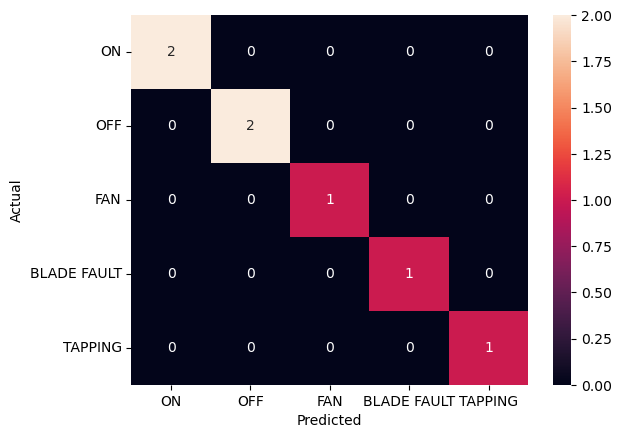

In [22]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()
plot_confusion_matrix(y_test, y_pred, labels=my_classes)

## 對測試集驗證

In [24]:
valid = pd.read_csv('./dataset/test.csv')
valid.head()

,filename,label,target
0,dataset/test/FAN_GUARDS_20201210144646_6.wav,FAN,2
1,dataset/test/OFF_20200318T204318_6.wav,OFF,1
2,dataset/test/BLADE FAULT_20200318T205806_6.wav,BLADE FAULT,3
3,dataset/test/OFF_20200318T204159_6.wav,OFF,1
4,dataset/test/OFF_20200318T204239_6.wav,OFF,1


In [26]:
y_pred=[]
error_list=[]
for i in range(len(valid)):
    index= i
    testing_wav_data = load_wav_16k_mono(valid['filename'][index])
    # play Audio
    # IPython.display.display(IPython.display.Audio(testing_wav_data, rate=sample_rate))
    scores, embeddings, spectrogram = model(testing_wav_data)
    result = my_model(embeddings).numpy()
    y_pred.append(result.mean(axis=0).argmax())
    inferred_class = my_classes[result.mean(axis=0).argmax()]
    print(f'filename: {valid["filename"][index]} pred: [{inferred_class} {scores.numpy().mean(axis=0).argmax()}] true: [{valid["label"][index]}]')
    if y_pred[i]!=valid["target"][index]:
        error_list.append(index)
error_list = np.array(error_list)

filename: dataset/test/FAN_GUARDS_20201210144646_6.wav pred: [FAN 337] true: [FAN]
filename: dataset/test/OFF_20200318T204318_6.wav pred: [OFF 494] true: [OFF]
filename: dataset/test/BLADE FAULT_20200318T205806_6.wav pred: [BLADE FAULT 392] true: [BLADE FAULT]
filename: dataset/test/OFF_20200318T204159_6.wav pred: [OFF 494] true: [OFF]
filename: dataset/test/OFF_20200318T204239_6.wav pred: [OFF 494] true: [OFF]
filename: dataset/test/OFF_20200318T204107_6.wav pred: [OFF 494] true: [OFF]
filename: dataset/test/TAPPING_20200318T205340_6.wav pred: [TAPPING 398] true: [TAPPING]
filename: dataset/test/BLADE FAULT_20200318T205628_6.wav pred: [BLADE FAULT 412] true: [BLADE FAULT]
filename: dataset/test/ON_20200318T204538_6.wav pred: [ON 510] true: [ON]
filename: dataset/test/BLADE FAULT_20200318T205711_6.wav pred: [BLADE FAULT 412] true: [BLADE FAULT]
filename: dataset/test/OFF_20210210T011501_6.wav pred: [OFF 494] true: [OFF]
filename: dataset/test/ON_20200318T204907_6.wav pred: [ON 490] tru

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(valid['target'].values, y_pred))
print("Accuracy:", accuracy_score(valid['target'].values, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Accuracy: 1.0


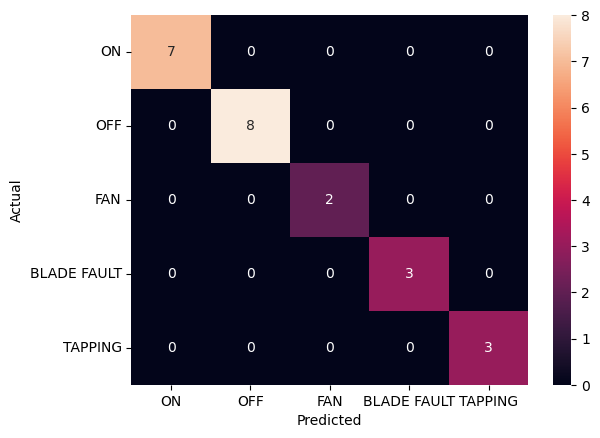

In [28]:
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()
plot_confusion_matrix(valid['target'].values, y_pred, labels=my_classes)

## 匯出ONNX模型

In [84]:
import tf2onnx
import onnx
onnx_model, _ = tf2onnx.convert.from_keras(my_model, opset=14)
onnx.save(onnx_model, "./model/tf_model.onnx")

2024-01-27 23:09:42.421700: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-01-27 23:09:42.421855: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-01-27 23:09:42.465757: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-01-27 23:09:42.465896: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
